In [1]:
# imports
import pandas as pd
import os

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, Input, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random 
import numpy as np 

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import datetime
from datetime import timedelta

import polars as pl

import seaborn as sns

import data_preprocessing
from data_integration import combine_data, read_data

In [ ]:
"""
    Calls the "read_data()" function from file "data_integration.py"
    Calls the "combine_data()" function from file "data_integration.py"
    Parameter:
    - 1: combines only glucose data
    - 2: combines glucose and dempgraphics
    - 3: combines glucose and heartrate
    Output: This function returns the intrgrated dataset included the restricted databases if downloaded and added to folder "datasets for T1D"
 """
# reads all datasets, if they are stored in the required folder DiaData/datasets for T1D/...
restricted_list = read_data(read_all = True)

In [ ]:
combined_main = combine_data(1, restricted_list)  

## Outlier detection

In [ ]:
# applies outlier removal
data_cleaned = data_preprocessing.remove_outliers(combined_main, value = "GlucoseCGM", modus = "glucose", subject = "PtID")

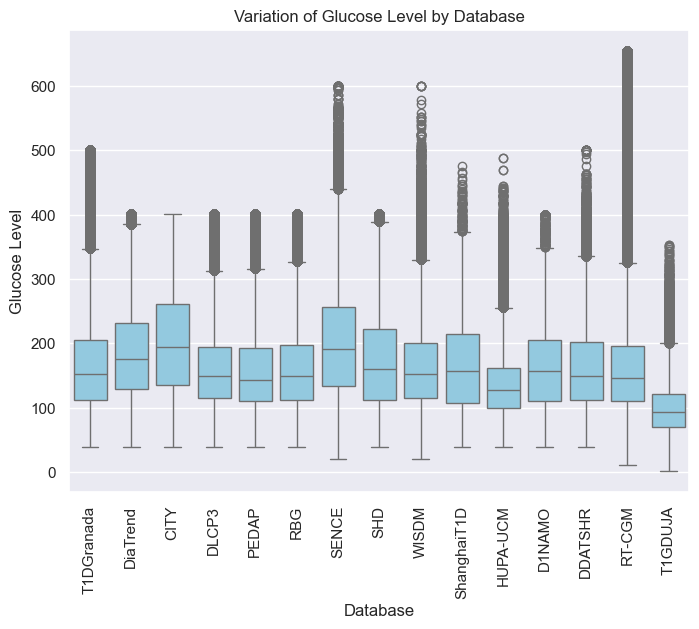

In [11]:
# Create boxplot
plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.boxplot(x='Database', y='GlucoseCGM', data=combined_main, showfliers=True, color='skyblue')  
plt.xticks(rotation=90)
# Add title and labels
plt.title("Variation of Glucose Level by Database")
plt.suptitle("")  
plt.xlabel("Database")
plt.ylabel("Glucose Level")
plt.show()

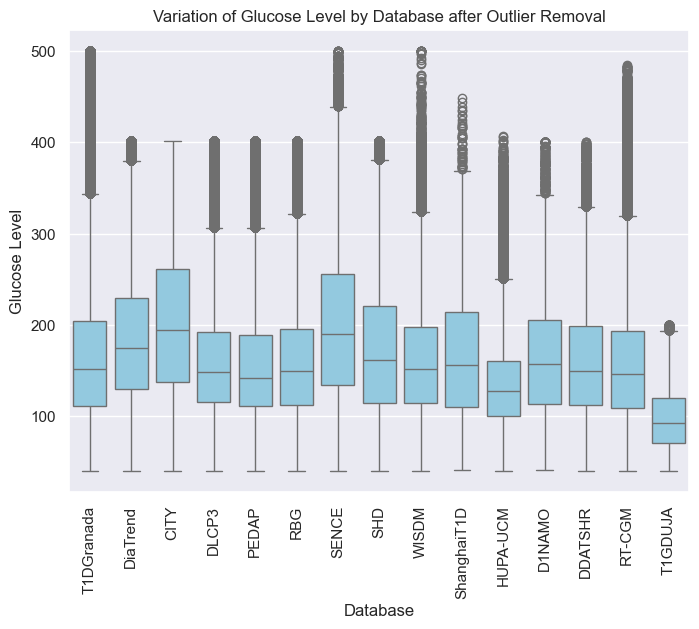

In [12]:
# Create boxplot
plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
sns.boxplot(x='Database', y='GlucoseCGM', data=data_cleaned, showfliers=True, color='skyblue')  
plt.xticks(rotation=90)
# Add title and labels
plt.title("Variation of Glucose Level by Database after Outlier Removal")
plt.suptitle("")  
plt.xlabel("Database")
plt.ylabel("Glucose Level")
plt.show()

Text(0, 0.5, 'Glucose Level')

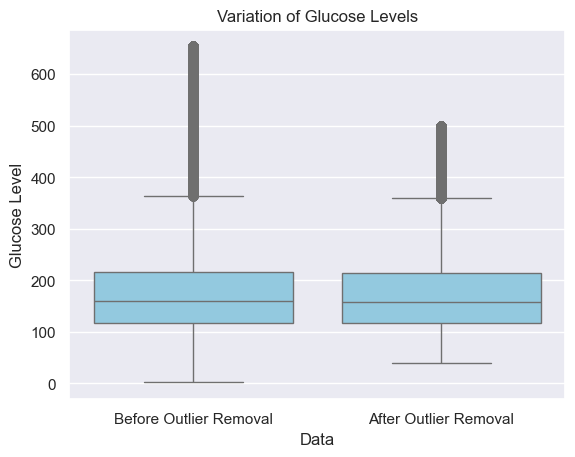

In [ ]:
combi = combined_main.copy()
combi['Data'] = 'Before Outlier Removal'

df_int = data_cleaned.copy()
df_int['Data'] = 'After Outlier Removal'


# Combine into one DataFrame
combined_both = pd.concat([combi, df_int])
combined_both = combined_both.reset_index(drop=True)


# Plot
sns.set_theme(style="darkgrid")
sns.boxplot(x='Data', y='GlucoseCGM', data=combined_both,showfliers=True, color='skyblue')
plt.title('Comparison of Value Distributions')
plt.title("Variation of Glucose Levels")
plt.suptitle("")  
plt.ylabel("Glucose Level")

## Missing value imputation

In [4]:
# linear interpolation is used for gaps which are less than 30 minute (6 consecuitve datapoints)
df_interpolated = data_cleaned.copy()
df_interpolated['GlucoseCGM'] = df_interpolated.groupby('PtID')['GlucoseCGM'].transform(
    lambda x: data_preprocessing.gap_limited_interpolation(x, limit=6)
)

# stineman interpolation for values between 30 adn 120 minutes
df_interpolated_stine = df_interpolated.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.interpolate_stineman_group(x, timestamp = "ts", value = "GlucoseCGM", llimit=6, ulimit=24))
df_interpolated_stine = df_interpolated_stine.sort_index()

In [5]:
# as a comparison, a copy of the cleaned dataset before imputation is made
only_interpolated = data_cleaned.copy()

# missing values of this copy are imputed with linear interpolation for all gaps lengths
only_interpolated['GlucoseCGM'] = only_interpolated.groupby('PtID')['GlucoseCGM'].transform(lambda group: group.interpolate(method='linear'))

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_10884/383817101.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_10884/383817101.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


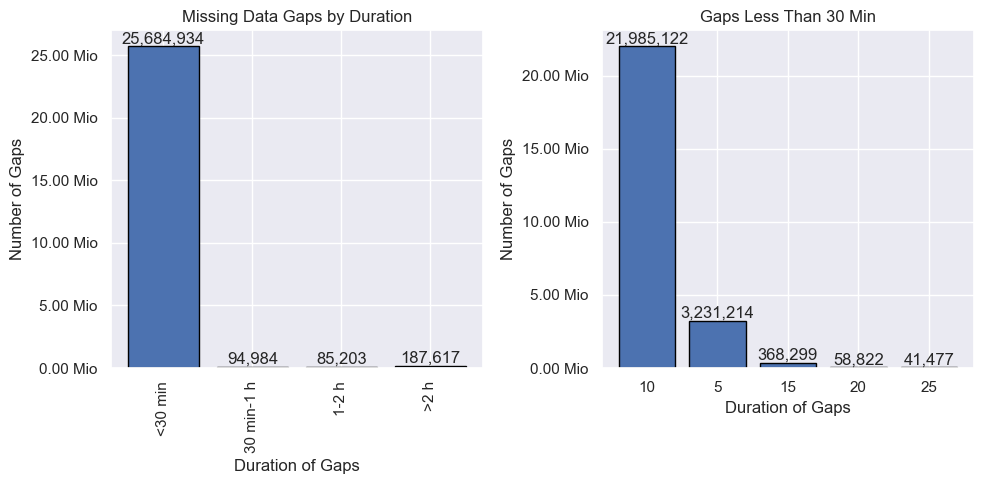

In [16]:
from matplotlib.ticker import FuncFormatter
# plots missing values to explore the data quality

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# the dataframe is copied
df_glc_missing = combined_main.copy()
# first, missing blocks are identified 
df_glc_missing["missing"] = df_glc_missing["GlucoseCGM"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
# groups by the identified gaps
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# one row of missing data equals 5 minutes, so the length of gap is multiplied by 5
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    ">2 h"
]
# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates the bin groups
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# filters to only less than 30 minute gaps
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the missing values count per created group and for the second group of less than 30 minutes in 5 minute intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the barchart of all missing value groups
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor="black")
ax1.set_title("Missing Data Gaps by Duration")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.2f} Mio"

# applyies formatter to axis
ax1.yaxis.set_major_formatter(FuncFormatter(millions))
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# plots the numbers on the bar
'''for bar in ax1.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax1.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
    
for bar in ax1.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# plots the missing values distribution less than 30 minutes as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

'''# adda text labels on top of each bar
for bar in ax2.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax2.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
for bar in ax2.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# applies formatter to axis 
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.set_xticklabels(ax2.get_xticklabels())

# layout
plt.tight_layout()
plt.show()

/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_3166/1072839694.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_3166/1072839694.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels())


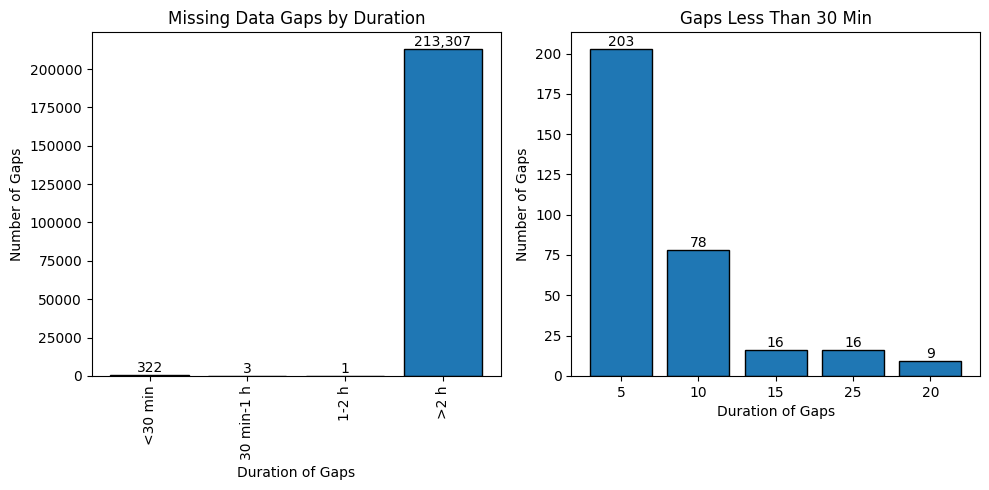

In [9]:
from matplotlib.ticker import FuncFormatter
# plots missing values to explore the data quality

# function to show both value and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        val_mio = round(val / 1_000_000, 1)
        return f"{val} ({pct:.1f}%)"
    return my_autopct

# the dataframe is copied
df_glc_missing = df_interpolated_stine.copy()
# first, missing blocks are identified 
df_glc_missing["missing"] = df_glc_missing["GlucoseCGM"].isna()

# uses groupby with cumsum to find continuous blocks
df_glc_missing["gap_id"] = (df_glc_missing["missing"] != df_glc_missing["missing"].shift()).cumsum()
# groups by the identified gaps
na_groups = df_glc_missing[df_glc_missing["missing"]].groupby("gap_id").size().reset_index(name="missing_count")
# one row of missing data equals 5 minutes, so the length of gap is multiplied by 5
na_groups["missing_count_time"] = na_groups["missing_count"] * 5

# categorizes durations based on specified bins and labels
bins = [0,30,60,120,na_groups["missing_count_time"].max()]
labels = [
    "<30 min",
    "30 min-1 h",
    "1-2 h",
    ">2 h"
]
# converts durations to timedelta seconds for binning
duration_bins = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)

# counts number of gaps per duration range
gap_counts = duration_bins.value_counts().sort_index()

# creates the bin groups
na_groups["MissingGroup"] = pd.cut(na_groups["missing_count_time"], bins=bins, labels=labels, right=False)
# filters to only less than 30 minute gaps
count_30_missing = na_groups[na_groups["MissingGroup"] ==  "<30 min"]["missing_count_time"].value_counts()

# plots the missing values count per created group and for the second group of less than 30 minutes in 5 minute intervals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plots the barchart of all missing value groups
ax1.bar(gap_counts.index.astype(str), gap_counts.values, edgecolor="black")
ax1.set_title("Missing Data Gaps by Duration")
ax1.set_xlabel("Duration of Gaps")
ax1.set_ylabel("Number of Gaps")

# formatter function
def millions(x, pos):
    return f"{x*1e-6:.2f} Mio"

# applyies formatter to axis
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# plots the numbers on the bar
'''for bar in ax1.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax1.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
    
for bar in ax1.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax1.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# plots the missing values distribution less than 30 minutes as a bar chart
ax2.bar(count_30_missing.index.astype(str), count_30_missing.values, width=0.8, edgecolor="black")
ax2.set_title("Gaps Less Than 30 Min")
ax2.set_xlabel("Duration of Gaps")
ax2.set_ylabel("Number of Gaps")

'''# adda text labels on top of each bar
for bar in ax2.patches:
    height = bar.get_height()
    # Converts to millions, cleans up trailing zeros
    label = f"{height / 1e6:.2f} Mio".rstrip("0").rstrip(".")  
    ax2.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha="center", va="bottom")'''
for bar in ax2.patches:
    height = bar.get_height()
    label = f"{int(height):,}"  # adds comma separators for readability
    ax2.text(
        bar.get_x() + bar.get_width() / 2,  # center of the bar
        height,                             # top of the bar
        label,                              # text to display
        ha="center", va="bottom"
    )

# applies formatter to axis 
ax2.set_xticklabels(ax2.get_xticklabels())

# layout
plt.tight_layout()
plt.show()

In [ ]:
def plot_missing_values(data_cleaned, df_interpolated_stine, only_interpolated, subject):

    subset_raw = data_cleaned[data_cleaned['PtID'] == subject]
    subset = df_interpolated_stine[df_interpolated_stine['PtID'] == subject]
    subset_onlyl = only_interpolated[only_interpolated['PtID'] == subject]

    # marks missing values
    df = subset_raw.copy()
    df.set_index('ts', inplace=True)
    is_nan = df['GlucoseCGM'].isna().astype(int)

    # run-length encoding via diff
    df['group'] = (is_nan.diff(1) != 0).cumsum()
    nan_groups = df[is_nan == 1].groupby('group')

    # finds first group with length = 12 
    for group_id, group_df in nan_groups:
        if len(group_df) >= 13 and len(group_df) < 24:
            start_time = group_df.index[0]
            end_time = group_df.index[len(group_df) - 1]
            print(f"First 1-hour NaN gap starts at: {start_time}, ends at: {end_time}")
            break
    else:
        print("No 1-hour gap of continuous missing values found.")

    # defines time range to plot
    start_date = start_time - timedelta(hours=1) 
    end_date = start_time + timedelta(hours=8)

    raw_week = subset_raw[(subset_raw['ts'] >= start_date) & (subset_raw['ts'] <= end_date)]
    imputed_week = subset[(subset['ts'] >= start_date) & (subset['ts'] <= end_date)]
    linear_imputed_week = subset_onlyl[(subset_onlyl['ts'] >= start_date) & (subset_onlyl['ts'] <= end_date)]

    subset_raw.set_index('ts', inplace=True)
    subset.set_index('ts', inplace=True)
    subset_onlyl.set_index('ts', inplace=True)

    df_imputed_masked = imputed_week.copy()
    df_imputed_masked['GlucoseCGM'] = imputed_week['GlucoseCGM'].where(raw_week['GlucoseCGM'].isna())

    df_imputed_masked_l = linear_imputed_week.copy()
    df_imputed_masked_l['GlucoseCGM'] = linear_imputed_week['GlucoseCGM'].where(raw_week['GlucoseCGM'].isna())



    raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')
    df_imputed_masked['date'] = pd.to_datetime(df_imputed_masked['ts'], format='%Y-%m-%d %H:%M:%S')
    df_imputed_masked_l['date'] = pd.to_datetime(df_imputed_masked_l['ts'], format='%Y-%m-%d %H:%M:%S')

    plt.figure(figsize=(12, 6))
    plt.plot(raw_week['date'], raw_week['GlucoseCGM'], label='Raw Glucose Levels', marker='o', linestyle='-', alpha=0.7)
    plt.plot(df_imputed_masked['date'], df_imputed_masked['GlucoseCGM'], label='Imputed Glucose Levels', marker='x', linestyle='--', alpha=0.7)
    plt.plot(df_imputed_masked_l['date'], df_imputed_masked_l['GlucoseCGM'], label='Linearly Imputed Glucose Levels', linestyle='-', alpha=0.5)

    plt.title(f"Raw vs Imputed Data of Subject: {subject}")
    plt.xlabel('Date')
    plt.ylabel('Glucose Level')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

First 1-hour NaN gap starts at: 2000-07-13 21:00:00, ends at: 2000-07-13 22:10:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_28473/831209291.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


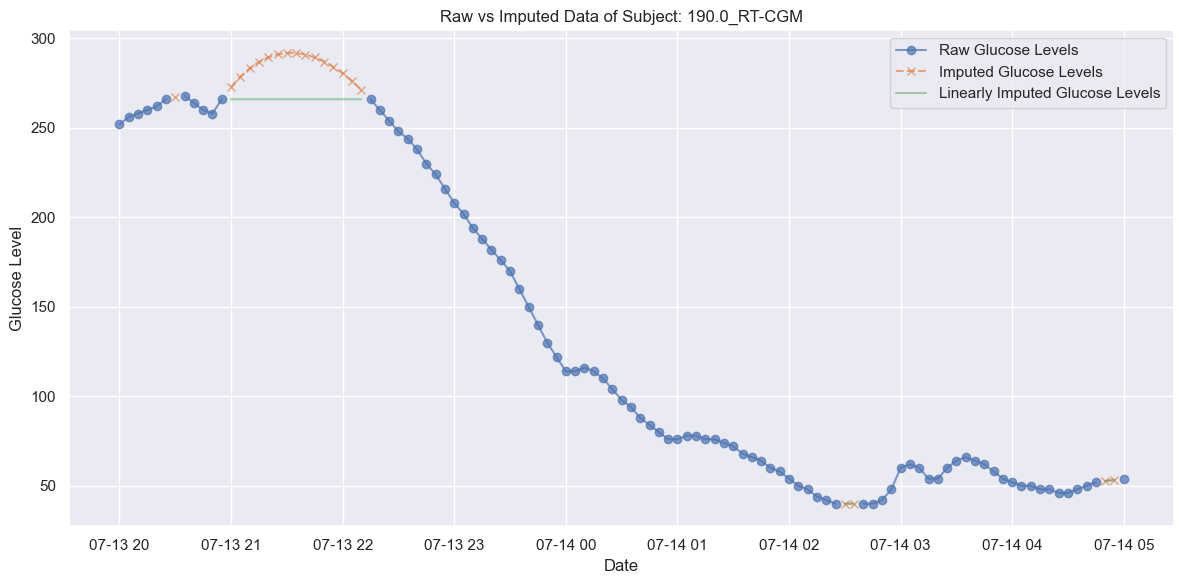

In [7]:
sns.set_theme(style="darkgrid")
plot_missing_values(data_cleaned, df_interpolated_stine, only_interpolated, "190.0_RT-CGM")

First 1-hour NaN gap starts at: 2000-03-16 04:30:00, ends at: 2000-03-16 05:40:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_24892/572875875.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


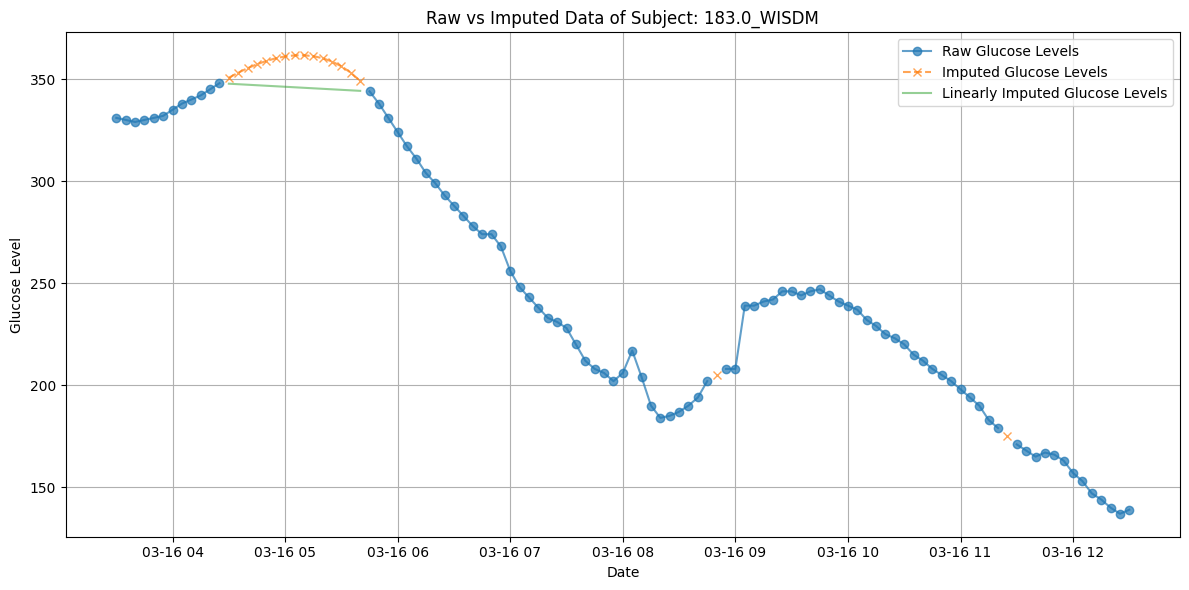

In [ ]:
plot_missing_values(data_cleaned, df_interpolated_stine, only_interpolated, "183.0_WISDM")

First 1-hour NaN gap starts at: 2018-02-14 09:25:00, ends at: 2018-02-14 11:00:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_24892/572875875.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


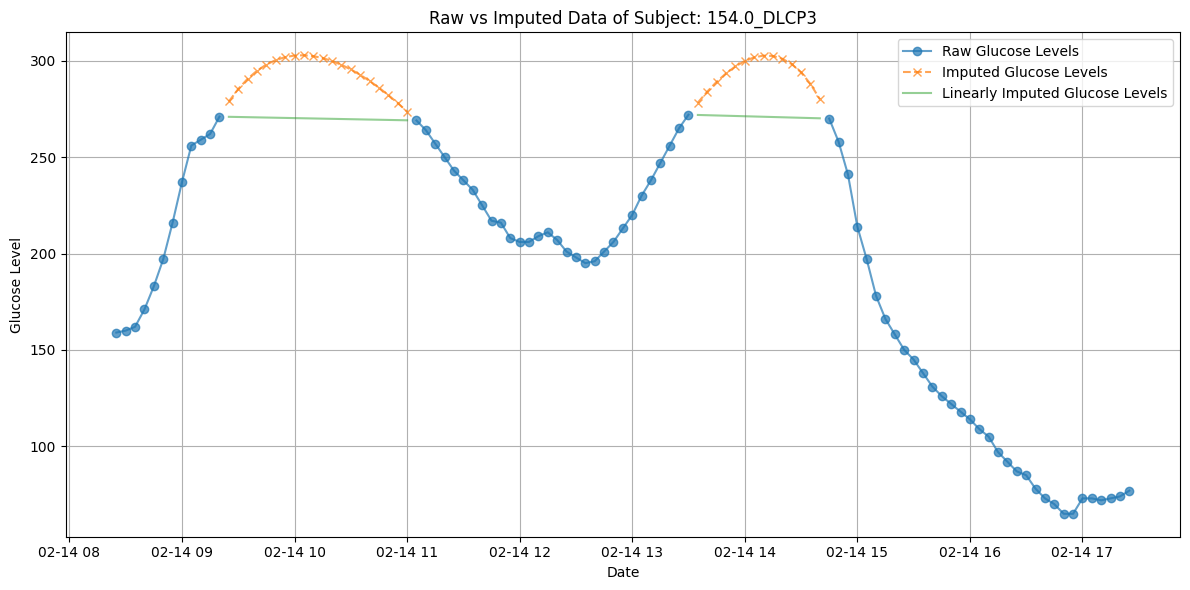

In [ ]:
plot_missing_values(data_cleaned, df_interpolated_stine, only_interpolated, "154.0_DLCP3")

First 1-hour NaN gap starts at: 2021-05-10 14:00:00, ends at: 2021-05-10 15:35:00


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_24892/572875875.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_week['date'] = pd.to_datetime(raw_week['ts'], format='%Y-%m-%d %H:%M:%S')


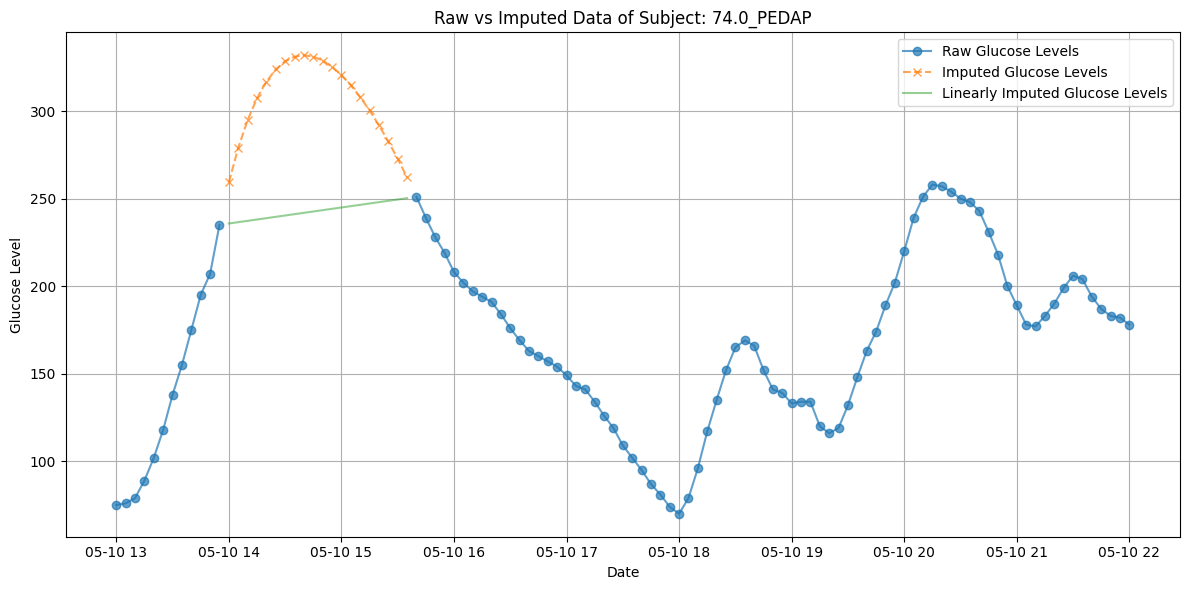

In [75]:
print_missing(data_cleaned, df_interpolated_stine, only_interpolated, "74.0_PEDAP")

## Assign classes and generate time series

In [ ]:
# dataset with interpolated values is copied
classes_df = df_interpolated_stine.copy()
# initially all classes are assigned a class -1
classes_df["Class"] = -1
# hypoglycemic values are defined as class 0 with values equal and lower than 70 mg/dL
classes_df.loc[classes_df["GlucoseCGM"] <= 70, "Class"] = 0

# calls the function class_generation to assing classes based on wanted intervals before hypogylcemia for each subject separately
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 5, 15, 1)) # 5-15 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 15, 30, 2)) # 15-30 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts", 30, 60, 3))  # 30-60 min
classes_df = classes_df.groupby("PtID", group_keys=False).apply(lambda x: data_preprocessing.class_generation(x,"ts",  60, 125, 4)) # 1-2 h
classes_df.loc[classes_df["Class"] == -1, "Class"] = 5

# sorts the glucose values by patient id and timestamps
df_sorted = classes_df.sort_values(by=['PtID', 'ts'])
# reindexes based on the sorted dataset
df_sorted = df_sorted.reset_index(drop=True)

In [15]:
df_sorted["Class"].value_counts()

Class
5    239134109
4      7057298
0      6701738
3      3579158
2      1913663
1      1355179
Name: count, dtype: int64

## Normalization

In [ ]:
# normalizes data 
df_min_max_scaled = data_preprocessing.normalize_data(df_sorted, 'GlucoseCGM')

## Genearte time series 

In [ ]:
# generates time series with sliding window approach
result = df_min_max_scaled.groupby('PtID').apply(lambda g: data_preprocessing.extract_valid_windows_GLC(g))

# filters out None values of subjects with insufficient data
filtered_result = [item for item in result if item is not None]
# unpacks the values
X_train, X_val, X_test, Y_train, Y_val, Y_test = zip(*filtered_result)

In [6]:
len(X_train)

2350

In [ ]:
# data are flattened to match the required shape
X_train = data_preprocessing.flatten_data(X_train, modus = "input", dim = 1)
X_val = data_preprocessing.flatten_data(X_val, modus = "input", dim = 1)
X_test = data_preprocessing.flatten_data(X_test, modus = "input", dim = 1)

(11983567, 25, 1)
(2569887, 25, 1)
(2569568, 25, 1)


In [ ]:
# data are flattened to match the required shape
Y_train = data_preprocessing.flatten_data(Y_train, modus = "output", dim = 1)
Y_val = data_preprocessing.flatten_data(Y_val, modus = "output", dim = 1)
Y_test = data_preprocessing.flatten_data(Y_test, modus = "output", dim = 1)

(11983567, 1)
(2569887, 1)
(2569568, 1)


In [23]:
np.unique(Y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([4155481,  773713, 1090699, 2026227, 3937447]))

In [24]:
np.unique(Y_val, return_counts=True)

(array([0, 1, 2, 3, 4]), array([870889, 167816, 237716, 440901, 852565]))

In [25]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3, 4]), array([856116, 169755, 240379, 445156, 858162]))

## Class undersampling

In [ ]:
def undersampling(X, y):
    # flattens y if it's 2D
    if isinstance(y, np.ndarray) and y.ndim == 2 and y.shape[1] == 1:
        y = y.ravel()

    # reshapes X for sampling
    num_samples, window_size, _ = X.shape
    X_reshaped = X.reshape(num_samples, window_size)

    # creates a balanced strategy
    from collections import Counter
    min_class_count = min(Counter(y).values())
    sampling_strategy = {int(cls): min_class_count for cls in np.unique(y)}

    # applies undersampling
    from imblearn.under_sampling import RandomUnderSampler
    undersample = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_under, y_under = undersample.fit_resample(X_reshaped, y)

    # reshapes back to 3D
    X_under = X_under.reshape(-1, window_size, 1)
    y_under = y_under.reshape(-1, 1)

    return X_under, y_under

In [27]:
X_train, Y_train = undersampling(X_train, Y_train)
X_val, Y_val = undersampling(X_val, Y_val)
X_test, Y_test = undersampling(X_test, Y_test)

## ResNet model

2025-05-26 16:34:58.336639: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-26 16:34:58.341789: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-26 16:34:58.341797: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-26 16:34:58.342237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 16:34:58.342624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-26 16:34:58.468535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Yo

Epoch 1/50


2025-05-26 16:35:00.983302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-26 16:41:34.038012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.63936, saving model to CustomModel.weights.hdf5
15112/15112 - 425s - loss: 0.6869 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.6394 - val_sparse_categorical_accuracy: 0.7239 - lr: 1.0000e-04 - 425s/epoch - 28ms/step
Epoch 2/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.63936 to 0.62621, saving model to CustomModel.weights.hdf5
15112/15112 - 430s - loss: 0.6473 - sparse_categorical_accuracy: 0.7192 - val_loss: 0.6262 - val_sparse_categorical_accuracy: 0.7311 - lr: 1.0000e-04 - 430s/epoch - 28ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.62621 to 0.62204, saving model to CustomModel.weights.hdf5
15112/15112 - 426s - loss: 0.6353 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.6220 - val_sparse_categorical_accuracy: 0.7301 - lr: 1.0000e-04 - 426s/epoch - 28ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.62204 to 0.62069, saving model to CustomModel.weights.hdf5
15112/15112 - 418s - loss: 0.6287 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.6207 - val_sparse_categorical_accuracy: 0.7309 - lr: 1.0000e-04 - 418s/epoch - 28ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.62069 to 0.61137, saving model to CustomModel.weights.hdf5
15112/15112 - 415s - loss: 0.6243 - sparse_categorical_accuracy: 0

2025-05-26 18:43:37.594411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26525/26525 [==============================] - 114s 4ms/step


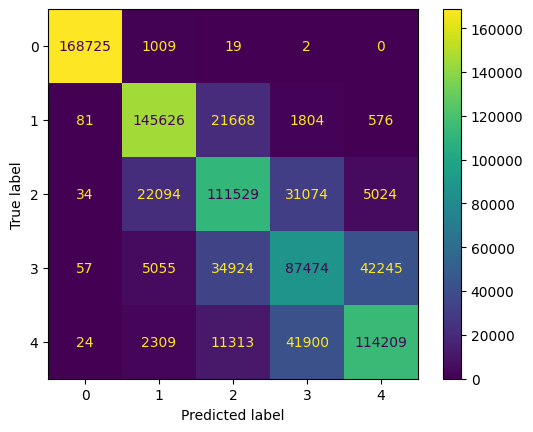

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    169755
           1       0.83      0.86      0.84    169755
           2       0.62      0.66      0.64    169755
           3       0.54      0.52      0.53    169755
           4       0.70      0.67      0.69    169755

    accuracy                           0.74    848775
   macro avg       0.74      0.74      0.74    848775
weighted avg       0.74      0.74      0.74    848775



In [ ]:
# source: https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/blob/master/ResNet.py
# 2DCNN layers were replaced with 1DCNN layers and He normal kernel initilization was included

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# 
# #!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 12 01:09:17 2016

@author: stephen
"""

from tensorflow import keras
import numpy as np
import pandas as pd

seed_value= 42  
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)



def build_resnet_1d(input_shape, n_feature_maps, nb_classes):
    inputs = Input(shape=input_shape)

    # Block 1
    x = BatchNormalization()(inputs)
    x = Conv1D(n_feature_maps, 8, padding='same',kernel_initializer='he_normal' )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps, 1, padding='same',kernel_initializer='he_normal')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Block 2
    x1 = x
    x = Conv1D(n_feature_maps * 2, 8, padding='same',kernel_initializer='he_normal')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps * 2, 1, padding='same',kernel_initializer='he_normal')(x1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Block 3
    x1 = x
    x = Conv1D(n_feature_maps * 2, 8, padding='same',kernel_initializer='he_normal')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 5, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(n_feature_maps * 2, 3, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(n_feature_maps * 2, 1, padding='same',kernel_initializer='he_normal')(x1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    # Output
    x = GlobalAveragePooling1D()(x)
    output = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    return model




# Define the early stopping callback
early_stopping = EarlyStopping(patience=5, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)

# initialize callbacks 
reduceLR =ReduceLROnPlateau(monitor='val_loss', patience=3, verbose= 1, mode='min', factor= 0.2, min_lr = 1e-5) 

checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min') 

callbacks= [early_stopping, checkpoint, reduceLR]

BUFFER_SIZE = len(X_train) #100_000
BATCH_SIZE = 256

Y_train_rs = Y_train.reshape(-1).astype('int32')
Y_val_rs = Y_val.reshape(-1).astype('int32')
Y_test_rs = Y_test.reshape(-1).astype('int32')

X_train_t = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_t = tf.convert_to_tensor(Y_train_rs, dtype=tf.int32)

X_val_t = tf.convert_to_tensor(X_val, dtype=tf.float32)
Y_val_t = tf.convert_to_tensor(Y_val_rs, dtype=tf.int32)

X_test_t = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_test_t = tf.convert_to_tensor(Y_test_rs, dtype=tf.int32)

train_ds_t = tf.data.Dataset.from_tensor_slices((X_train_t, Y_train_t))
train_ds = train_ds_t.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_t, Y_val_t)).batch(BATCH_SIZE)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# Build and train model
model_wang_resnet2 = build_resnet_1d((X_train.shape[1], X_train.shape[2]), 64, 5) 
model_wang_resnet2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['sparse_categorical_accuracy'])
model_wang_resnet2.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks, verbose=2)


# Evaluation of the model and Confusion Matrix
model_wang_resnet2.evaluate(X_test_t, Y_test_t)
predictions_model_wang_resnet2 = model_wang_resnet2.predict(X_test_t)
y_pred_model_wang_resnet2 = np.argmax(predictions_model_wang_resnet2, axis=1) 
ConfusionMatrixDisplay.from_predictions(
    Y_test_t, y_pred_model_wang_resnet2)
plt.show()

print(classification_report(Y_test_t, y_pred_model_wang_resnet2))

model_wang_resnet2.save("model_wang_resnet_MDB.keras")